In [1]:
SPECTRUM_FOLDERNAME = 'spectrums_cropped_small' # the folder containing the spectrums to load
IMG_HEIGHT = 200
IMG_WIDTH = 500
FILE_SUFFIX = "CROPPED_IMAGES_SMALL2"
EPOCHS = 100
EARLY_STOPPING_PATIENCE = 10

# Load Data

In [2]:
import pandas as pd

data = pd.read_csv('data_balanced_processed.csv', encoding="latin-1")
#data.drop('Unnamed: 0', axis=1, inplace=True)
data.head()

,drummer,session,id,style,simplified_style,bpm,beat_type,time_signature,midi_filename,audio_filename,...,rms_std,spectral_centroid_mean,spectral_centroid_std,spectral_bandwidth_mean,spectral_bandwidth_std,spectral_flatness_mean,spectral_flatness_std,tempogram_mean,tempogram_std,spectrum_filename
0,drummer1,drummer1/eval_session,drummer1/eval_session/1,funk/groove1,funk,138,1,4-4,drummer1/eval_session/1_funk-groove1_138_beat_...,drummer1/eval_session/1_funk-groove1_138_beat_...,...,0.056157,5608.665252,2501.480437,4647.658427,941.263597,0.090434,0.124045,0.294583,0.171183,drummer1/eval_session/1_funk-groove1_138_beat_...
1,drummer1,drummer1/eval_session,drummer1/eval_session/10,soul/groove10,funk,102,1,4-4,drummer1/eval_session/10_soul-groove10_102_bea...,drummer1/eval_session/10_soul-groove10_102_bea...,...,0.062846,7204.425221,3338.747216,5212.773742,1194.914650,0.148189,0.143111,0.267859,0.234713,drummer1/eval_session/10_soul-groove10_102_bea...
2,drummer1,drummer1/eval_session,drummer1/eval_session/2,funk/groove2,funk,105,1,4-4,drummer1/eval_session/2_funk-groove2_105_beat_...,drummer1/eval_session/2_funk-groove2_105_beat_...,...,0.061557,6172.809370,3874.975566,4711.894615,1483.392124,0.116454,0.132516,0.238676,0.153792,drummer1/eval_session/2_funk-groove2_105_beat_...
3,drummer1,drummer1/eval_session,drummer1/eval_session/3,soul/groove3,funk,86,1,4-4,drummer1/eval_session/3_soul-groove3_86_beat_4...,drummer1/eval_session/3_soul-groove3_86_beat_4...,...,0.053402,5704.099294,3309.100713,5098.568553,1251.293005,0.101191,0.128717,0.149444,0.144291,drummer1/eval_session/3_soul-groove3_86_beat_4...
4,drummer1,drummer1/eval_session,drummer1/eval_session/4,soul/groove4,funk,80,1,4-4,drummer1/eval_session/4_soul-groove4_80_beat_4...,drummer1/eval_session/4_soul-groove4_80_beat_4...,...,0.046688,8042.372855,3504.921958,5396.953176,999.442925,0.181278,0.149775,0.115379,0.128980,drummer1/eval_session/4_soul-groove4_80_beat_4...


In [136]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1200 entries, 0 to 1199
Data columns (total 38 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   drummer                  1200 non-null   object 
 1   session                  1200 non-null   object 
 2   id                       1200 non-null   object 
 3   style                    1200 non-null   object 
 4   simplified_style         1200 non-null   object 
 5   bpm                      1200 non-null   int64  
 6   beat_type                1200 non-null   int64  
 7   time_signature           1200 non-null   object 
 8   midi_filename            1200 non-null   object 
 9   audio_filename           1200 non-null   object 
 10  duration                 1200 non-null   float64
 11  split                    1200 non-null   object 
 12  start                    1200 non-null   float64
 13  end                      1200 non-null   float64
 14  times_sampled           

# Prepare Data

In [3]:
from sklearn.preprocessing import LabelEncoder

# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the target variable
data["encoded_style"] = label_encoder.fit_transform(data.simplified_style)
data.encoded_style.value_counts()

encoded_style
0    200
1    200
4    200
5    200
3    200
2    200
Name: count, dtype: int64

Because we sampled some audio files multiple times. We should prevent data leakage between train and test/validation sets. We do this by using the group shuffle split from scikit-learn. This messes up the distribution of genres a bit though. To find the best split, that has no data leakage and a good distribution of genres, we will use the forbidden technique of random state hacking! We are using it to create a good split and not to overfit the model, so it is fine i think.
We just check the genre distributions produced by different random states and choose the one, that differs the least from a perfectly balanced distributon.

In [39]:
from sklearn.model_selection import GroupShuffleSplit

# random state hacking
rnd_states = []
for i in range(9999):
    groups = data['audio_filename']
    gss = GroupShuffleSplit(n_splits=5, train_size=0.7, random_state=i)
    for train_indices, remaining_indices in gss.split(X=data, groups=groups):
        #GroupShuffleSplit.split() returns a tuple instead of Numpy.nparray when used outside of a for loop somehow. So I guess I need to fill this loop with code...
        useless_variable = None
        
    train_df = data.iloc[train_indices].sample(frac=1.0, random_state=42)
    remaining_df = data.iloc[remaining_indices]

    # calcuate how balanced the data sets are
    balanced_ratio = 1/6
    train_ratios = train_df.simplified_style.value_counts(normalize=True).values
    remaining_ratios = remaining_df.simplified_style.value_counts(normalize=True).values
    train_offset = (abs(train_ratios - balanced_ratio)).sum()
    remaining_offset = (abs(remaining_ratios - balanced_ratio)).sum()
    balanced_offset = train_offset + remaining_offset # the lower the better
    
    # save random state i and blanced_offset in a dictionary
    rnd_states.append({'rnd_state': i, 'balanced_offset': balanced_offset})

# print the random state with the lowest balanced offset
print(min(rnd_states, key=lambda x:x['balanced_offset']))

group_shuffle_rnd_state = min(rnd_states, key=lambda x:x['balanced_offset']).get('rnd_state')

{'rnd_state': 726, 'balanced_offset': 0.04131377814501136}


In [36]:
# prevent data leakage by grouping splits by audio_filename
groups = data['audio_filename']
gss = GroupShuffleSplit(n_splits=5, train_size=0.7, random_state=group_shuffle_rnd_state)
for train_indices, remaining_indices in gss.split(X=data, groups=groups):
    #GroupShuffleSplit.split() returns a tuple instead of Numpy.nparray when used outside of a for loop somehow. So I guess I need to fill this loop with code...
    useless_variable = None


# create dataframe from group split indices and shuffle the train dataframe
data_train = data.iloc[train_indices].sample(frac=1.0, random_state=42)
remaining_data = data.iloc[remaining_indices]

# check for data leakage
print('Data leakage =', data_train['audio_filename'].isin(remaining_data['audio_filename']).any())

# check genre distribution
print("\nTrain data genre distribution")
print(data_train.simplified_style.value_counts(normalize=True))

print("\nRemaining data genre distribution")
print(remaining_data.simplified_style.value_counts(normalize=True))

Data leakage = False

Train data genre distribution
simplified_style
latin     0.169082
rock      0.167874
funk      0.167874
hiphop    0.166667
jazz      0.166667
pop       0.161836
Name: proportion, dtype: float64

Remaining data genre distribution
simplified_style
pop       0.177419
jazz      0.166667
hiphop    0.166667
funk      0.163978
rock      0.163978
latin     0.161290
Name: proportion, dtype: float64


In [163]:
from sklearn.model_selection import train_test_split

# # split the remaining data into test and validation data sets. No need to worry about data leakage, because these datasets are not used for training.
data_test, data_validation = train_test_split(remaining_data, test_size=0.5, random_state=42,)
data_test.shape

# check the distribution after the split
print(data_train.shape, data_test.shape, data_validation.shape, )
print("Train data share: ", data_train.shape[0] / data.shape[0])
print("Validation data share: ", data_validation.shape[0]/ data.shape[0])
print("Test data share: ", data_test.shape[0] / data.shape[0])

Train data genre distribution
simplified_style
latin     0.200946
funk      0.165485
jazz      0.163121
pop       0.161939
hiphop    0.156028
rock      0.152482
Name: proportion, dtype: float64


# Convolutional Neural Network

Image Generators are the dataloaders for the CNN. They just define how the images are "fed" to the cnn, like where is the path to the images, what are the labels to predict

In [140]:
data_test.head()

,drummer,session,id,style,simplified_style,bpm,beat_type,time_signature,midi_filename,audio_filename,...,spectral_centroid_mean,spectral_centroid_std,spectral_bandwidth_mean,spectral_bandwidth_std,spectral_flatness_mean,spectral_flatness_std,tempogram_mean,tempogram_std,spectrum_filename,encoded_style
471,drummer7,drummer7/session3,drummer7/session3/130,soul,funk,105,1,4-4,drummer7/session3/130_soul_105_beat_4-4.mid,drummer7/session3/130_soul_105_beat_4-4.wav,...,8678.400491,2756.215090,5944.971373,732.330488,0.201400,0.151029,0.158577,0.141107,drummer7/session3/130_soul_105_beat_4-4_14.062...,0
925,drummer1,drummer1/session1,drummer1/session1/183,afrocuban,latin,105,1,4-4,drummer1/session1/183_afrocuban_105_beat_4-4.mid,drummer1/session1/183_afrocuban_105_beat_4-4.wav,...,4851.674518,2785.777991,4626.445214,1264.859072,0.060802,0.112802,0.260052,0.198180,drummer1/session1/183_afrocuban_105_beat_4-4_1...,3
277,drummer7,drummer7/session1,drummer7/session1/8,rock,rock,93,1,4-4,drummer7/session1/8_rock_93_beat_4-4.mid,drummer7/session1/8_rock_93_beat_4-4.wav,...,8916.871598,2201.616088,5760.158752,769.809291,0.158932,0.131173,0.128817,0.159382,drummer7/session1/8_rock_93_beat_4-4_117.418-1...,5
344,drummer7,drummer7/session3,drummer7/session3/22,pop/soft,pop,83,1,4-4,drummer7/session3/22_pop-soft_83_beat_4-4.mid,drummer7/session3/22_pop-soft_83_beat_4-4.wav,...,3716.412372,1946.726963,3473.626677,994.526490,0.028910,0.079902,0.119428,0.117630,drummer7/session3/22_pop-soft_83_beat_4-4_5.27...,4
767,drummer7,drummer7/session3,drummer7/session3/11,pop/soft,pop,83,1,4-4,drummer7/session3/11_pop-soft_83_beat_4-4.mid,drummer7/session3/11_pop-soft_83_beat_4-4.wav,...,5562.921541,1982.646115,4213.908259,767.095478,0.069639,0.095735,0.093665,0.099808,drummer7/session3/11_pop-soft_83_beat_4-4_59.7...,4


In [141]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

path_images = os.path.join('..', 'Datasets', SPECTRUM_FOLDERNAME)

BATCH_SIZE = 32

# IMG_HEIGHT_OFFSET = 35
# IMG_WIDTH_OFFSET = 89
# CROPPED_HEIGHT = 307
# CROPPED_WIDTH = 717

# # Define the custom preprocessing function
# def crop_image(image):
#     cropped_image = tf.image.crop_to_bounding_box(
#         image,
#         offset_height = IMG_HEIGHT_OFFSET, 
#         offset_width = IMG_WIDTH_OFFSET, 
#         target_height = CROPPED_HEIGHT, 
#         target_width = CROPPED_WIDTH
#     )
#     return cropped_image

# Normalize images and add the custom preprocessing function
image_generator = ImageDataGenerator(
    rescale=1.0/255,
    #preprocessing_function=crop_image
)

# Define the data generators
train_generator = image_generator.flow_from_dataframe(
    dataframe=data_train,
    directory=path_images,
    x_col="spectrum_filename",
    y_col="simplified_style",
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    color_mode="grayscale"
)

val_generator = image_generator.flow_from_dataframe(
    dataframe=data_validation,
    directory=path_images,
    x_col="spectrum_filename",
    y_col="simplified_style",
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    color_mode="grayscale", #add color mode,
    shuffle=False,  # this is crucial for later evaluation!
)

test_generator = image_generator.flow_from_dataframe(
    dataframe=data_test,
    directory=path_images,
    x_col="spectrum_filename",
    y_col="simplified_style",
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    color_mode="grayscale", #add color mode,
    shuffle=False,  # this is crucial for later evaluation!
)

Found 1020 validated image filenames belonging to 6 classes.
Found 90 validated image filenames belonging to 6 classes.
Found 90 validated image filenames belonging to 6 classes.


In [142]:
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense
from keras.models import Model

# Define the input shape
inputs = Input(shape=(IMG_HEIGHT, IMG_WIDTH, 1))

# Define the CNN architecture
x = Conv2D(32, (3, 3), activation='relu')(inputs)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(128, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(128, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(128, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Flatten()(x)
x = Dense(64, activation='relu')(x)
outputs = Dense(6, activation="softmax")(x)

# Create the model
cnn_model = Model(inputs=inputs, outputs=outputs)

cnn_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 200, 500, 1)]     0         
                                                                 
 conv2d_31 (Conv2D)          (None, 198, 498, 32)      320       
                                                                 
 max_pooling2d_31 (MaxPoolin  (None, 99, 249, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_32 (Conv2D)          (None, 97, 247, 64)       18496     
                                                                 
 max_pooling2d_32 (MaxPoolin  (None, 48, 123, 64)      0         
 g2D)                                                            
                                                                 
 conv2d_33 (Conv2D)          (None, 46, 121, 128)      7385

In [143]:
import tensorflow as tf

def compileCNN(cnn):
    metrics = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]

    # Compile the model
    cnn.compile(optimizer='adam',
                loss='categorical_crossentropy', # used for one-hot encoded labels, which is done by the ImageDataGenerator
                metrics="accuracy") #metrics)
    
    return cnn

In [144]:
def createCallbacks(path):
    # Create a callback that saves the model's weights
    checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(filepath=path,
                                                    save_weights_only=True,    # saving only the weights, because we have the architecture of the model
                                                    verbose=1, 
                                                    monitor='val_accuracy',    # we are monitoring the accuracy on the validation set
                                                    mode='max',                # the greatest accuracy on the validation is the best outcome
                                                    save_best_only=True)       # we only want to save the best model. The other chechpoints are not interesting to us
    
    early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=EARLY_STOPPING_PATIENCE)

    return checkpoint_cb, early_stopping_cb

In [145]:
def trainCNN(cnn, train_generator, validation_generator, checkpoint_callback, early_stopping_callback):
    history = cnn.fit(
        train_generator,
        epochs=EPOCHS,
        validation_data=validation_generator,
        verbose=1,
        callbacks=[checkpoint_callback, early_stopping_callback],  # Pass callback to training
    )
    return cnn

In [146]:
filename = 'multiclass_cnn_' + FILE_SUFFIX + '.ckpt'
cnn_path = os.path.join('..', 'data', 'models', filename)

try:
    cnn_model.load_weights(cnn_path)
except:
    cnn_model = compileCNN(cnn_model)
    checkpoint_callback, early_stopping_callback = createCallbacks(cnn_path)
    cnn_model = trainCNN(cnn_model, train_generator, val_generator, checkpoint_callback, early_stopping_callback)

Epoch 1/100
32/32 [==============================] - ETA: 0s - loss: 1.7951 - accuracy: 0.1706
Epoch 1: val_accuracy improved from -inf to 0.22222, saving model to ..\data\models\multiclass_cnn_CROPPED_IMAGES_SMALL2.ckpt
32/32 [==============================] - 258s 7s/step - loss: 1.7951 - accuracy: 0.1706 - val_loss: 1.7893 - val_accuracy: 0.2222
Epoch 2/100
32/32 [==============================] - ETA: 0s - loss: 1.7475 - accuracy: 0.2294
Epoch 2: val_accuracy improved from 0.22222 to 0.25556, saving model to ..\data\models\multiclass_cnn_CROPPED_IMAGES_SMALL2.ckpt
32/32 [==============================] - 94s 3s/step - loss: 1.7475 - accuracy: 0.2294 - val_loss: 1.7951 - val_accuracy: 0.2556
Epoch 3/100
32/32 [==============================] - ETA: 0s - loss: 1.7030 - accuracy: 0.2775
Epoch 3: val_accuracy improved from 0.25556 to 0.28889, saving model to ..\data\models\multiclass_cnn_CROPPED_IMAGES_SMALL2.ckpt
32/32 [==============================] - 74s 2s/step - loss: 1.7030 - ac

# Evaluation

In [147]:
test_loss, test_accuracy = cnn_model.evaluate(test_generator)
print(f'Test Accuracy: {test_accuracy*100:.2f}%')

3/3 [==============================] - 1s 524ms/step - loss: 6.2446 - accuracy: 0.3222
Test Accuracy: 32.22%


In [148]:
import numpy as np

# Predict the labels for the test set
test_generator.reset()  # Resetting ensures the generator starts from the beginning
predictions = cnn_model.predict(test_generator)

# Convert predictions to class indices (if using softmax output)
predicted_classes = np.argmax(predictions, axis=1)

# True labels from the test generator
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())  # Get the class labels

3/3 [==============================] - 7s 4s/step


In [149]:
from sklearn.metrics import classification_report, hamming_loss, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_model(true_classes, predicted_classes):
    # Classification report
    report = classification_report(true_classes, predicted_classes, target_names=class_labels)
    print("Classification Report:\n", report)

    # Hamming Loss
    h_loss = hamming_loss(true_classes, predicted_classes)
    print("Hamming Loss:", h_loss)

    # Confusion Matrix
    conf_matrix = confusion_matrix(true_classes, predicted_classes)
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()
    
    return report, h_loss

In [150]:
# Convert the classification report to a markdown table
def convert_to_markdown(report, hamming_loss, image_path=None, file_suffix=FILE_SUFFIX):
    lines = report.strip().split('\n')
    headers = lines[0].split()
    table = "| " + " | ".join(headers) + " |\n"
    table += "| " + " | ".join(['---'] * len(headers)) + " |\n"
    
    for line in lines[1:]:
        row = " | ".join(line.split())
        table += "| " + row + " |\n"
    
    markdown_content = f"# Classification Report for {file_suffix}\n\n"
    markdown_content += f"__Hamming Loss__ = {hamming_loss}\n\n{table}\n"
    
    if image_path:
        markdown_content += f"\n![Image]({image_path})\n"
    
    return markdown_content

def save_evaluation(report, h_loss, file_suffix=FILE_SUFFIX):
    eval_path = os.path.join('..', 'evaluation')
    conf_matrix_path = os.path.join(eval_path, 'images', 'confusion_matrix_' + file_suffix + '.png')
    markdwon_path = os.path.join(eval_path, 'markdown', 'classification_report_' + file_suffix + '.md')
    plt.savefig(conf_matrix_path)
    #plt.close()

    # Generate markdown content
    markdown_content = convert_to_markdown(report, h_loss, conf_matrix_path, file_suffix=file_suffix)

    # Write to a markdown file
    with open(markdwon_path, "w") as file:
        file.write(markdown_content)

Classification Report:
               precision    recall  f1-score   support

        funk       0.29      0.54      0.38        13
      hiphop       0.38      0.38      0.38        13
        jazz       0.19      0.20      0.19        15
       latin       0.33      0.38      0.36        13
         pop       0.50      0.31      0.38        16
        rock       0.33      0.20      0.25        20

    accuracy                           0.32        90
   macro avg       0.34      0.34      0.32        90
weighted avg       0.34      0.32      0.32        90

Hamming Loss: 0.6777777777777778


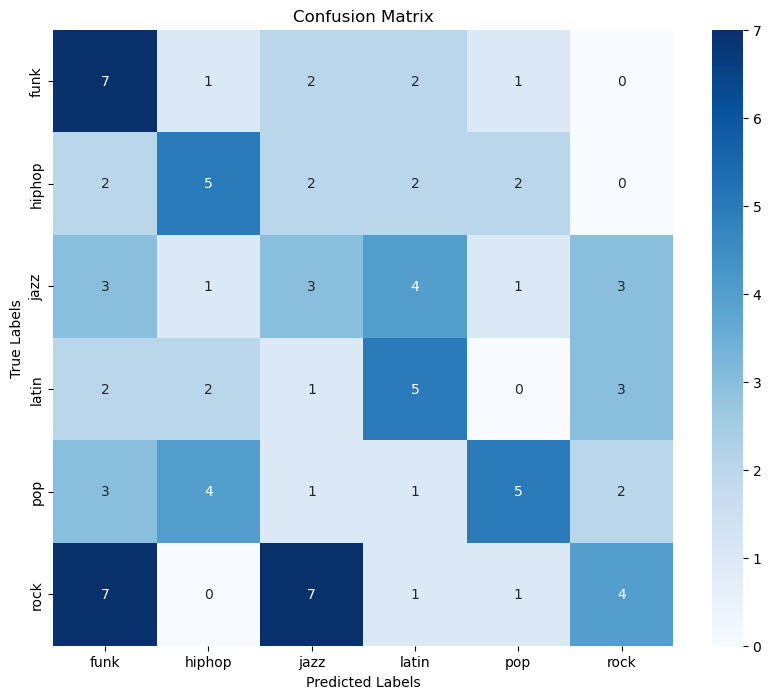

<Figure size 640x480 with 0 Axes>

In [151]:
report, h_loss = evaluate_model(true_classes, predicted_classes)
save_evaluation(report, h_loss)

### Baseline Predictions

In [152]:
random_baseline = []
all_5s_baseline = []

for i in range(len(true_classes)):
    random_baseline.append(np.random.randint(0, 6))
    all_5s_baseline.append(5)